In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [2]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
y_test = np.load('artifacts/Y_test.npz')['arr_0']

In [3]:
# Define function to train and evaluate a model
def train_evaluate(model, model_name):
    # Train
    model.fit(X_train, y_train)
    
    # Predict (logged scale)
    preds_log = model.predict(X_test)
    
    # Inverse transform to original scale for metrics
    preds = np.expm1(preds_log)
    y_test_orig = np.expm1(y_test)
    
    # Metrics
    mae = mean_absolute_error(y_test_orig, preds)
    rmse = np.sqrt(mean_squared_error(y_test_orig, preds))
    r2 = r2_score(y_test_orig, preds)
    
    # Feature importance (for tree-based)
    fi = None
    if hasattr(model, 'feature_importances_'):
        fi = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        fi = model.get_feature_importance()

    if fi is not None:
        feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
        importances = pd.Series(fi, index=feature_names).sort_values(ascending=False)
        print(f"\nTop 5 Features for {model_name}:\n{importances.head()}")
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [4]:
# Train base models
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

In [5]:
results = []
for name, model in models.items():
    results.append(train_evaluate(model, name))


Top 5 Features for XGBoost:
f29    0.135520
f32    0.130324
f42    0.128667
f36    0.069995
f40    0.068466
dtype: float32


/Users/nithilathawalampitiya/Documents/Projects/Datathon_Rootcode/datavenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Top 5 Features for LightGBM:
f0     349
f20    262
f21    161
f1     156
f27     97
dtype: int32

Top 5 Features for CatBoost:
f38    12.929012
f32    10.775134
f40    10.214041
f42    10.047643
f29     7.433816
dtype: float64


In [6]:
# Step 4: Compare in a table
results_df = pd.DataFrame(results)
print("\nBase Model Comparison:")
print(results_df)


Base Model Comparison:
      Model       MAE       RMSE        R2
0   XGBoost  8.286138  11.305230  0.698252
1  LightGBM  8.273400  11.271698  0.700040
2  CatBoost  8.263278  11.273426  0.699948


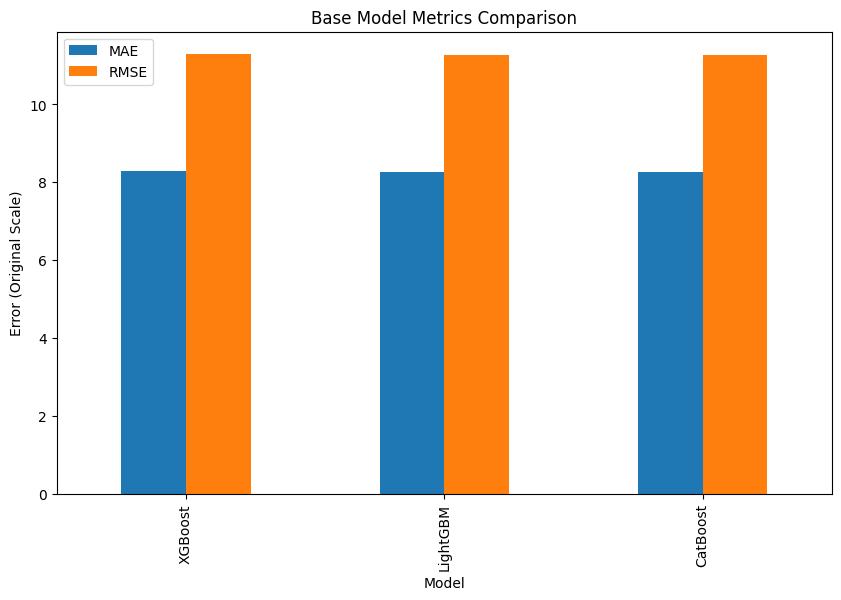

In [7]:
# Optional: Plot comparison
results_df.plot(x='Model', y=['MAE', 'RMSE'], kind='bar', figsize=(10, 6))
plt.title('Base Model Metrics Comparison')
plt.ylabel('Error (Original Scale)')
plt.show()